In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import warnings
import logging


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
x_train_val= np.load('/kaggle/input/time-series/x_train.npy')
y_train_val=np.load('/kaggle/input/time-series/y_train.npy')

In [5]:
print("X_train shape",x_train_val.shape)
print("Y_train shape",y_train_val.shape)

X_train shape (2429, 36, 6)
Y_train shape (2429,)


In [6]:
labels={0: "Wish",
1: "Another",
2: "Comfortably",
3: "Money",
4: "Breathe",
5: "Time",
6: "Brain",
7: "Echoes",
8: "Wearing",
9: "Sorrow",
10: "Hey",
11: "Shine"}

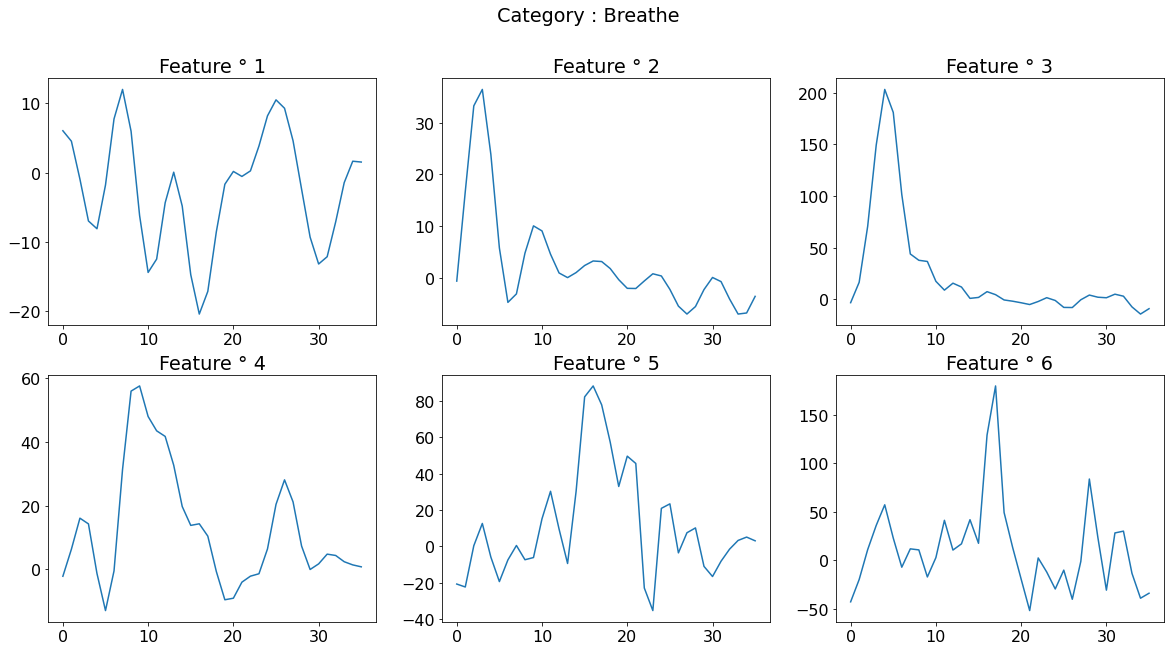

In [7]:
# UNDERSTANDING THE DATA : VISUALIZE

# At first it appears like: the data is represented on 36 pts time series, and for 
# each point of time there is a value for 6 different features; it is then 36 pts 
# time series of 6 different features

def plot_example(random_index, x,y ):
    example=x[random_index]
    example_label=y[random_index]

    n_points=example.shape[0] # 36
    n_features=example.shape[1] # 6

    counter=0
    fig, axs= plt.subplots(2, 3, figsize=(20,10))
    fig.suptitle('Category : '+labels[example_label])
    for i in range(n_features):
        row= counter//3
        col= counter%3
        example_on_ith_feature=example[:,i]
        axs[row,col].set_title('Feature ° '+str(i+1))
        axs[row,col].plot(example_on_ith_feature)
        counter=counter+1




random_index=np.random.randint(0,2428) 
plot_example(random_index,x_train_val,y_train_val)


TOTAL :  2429


{'Wish': 34,
 'Another': 123,
 'Comfortably': 270,
 'Money': 381,
 'Breathe': 62,
 'Time': 153,
 'Brain': 313,
 'Echoes': 68,
 'Wearing': 120,
 'Sorrow': 777,
 'Hey': 77,
 'Shine': 51}

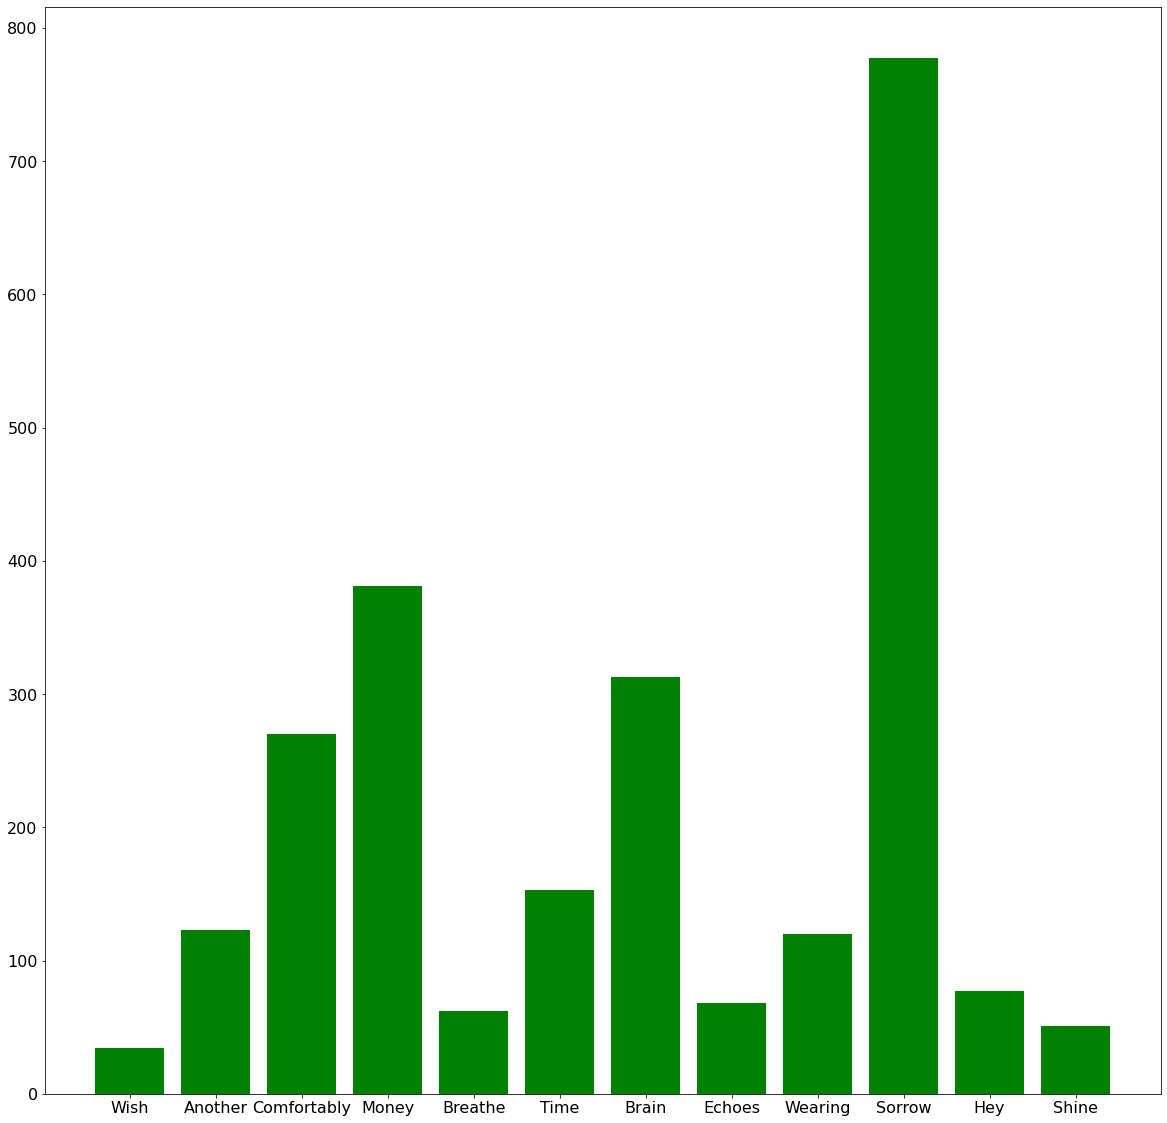

In [8]:
# CLASS REPARTITIONS



def class_rep(y_train_val):
    
    class_repartitions={"Wish":0,
    "Another":0,
    "Comfortably":0,
    "Money":0,
    "Breathe":0,
    "Time":0,
    "Brain":0,
    "Echoes":0,
    "Wearing":0,
    "Sorrow":0,
    "Hey":0,
    "Shine":0}
    
    for y in y_train_val:
        label=labels[y]
        class_repartitions[label]=class_repartitions[label]+1
    
    S=0
    for key in class_repartitions:
        S=S+class_repartitions[key]


    print("TOTAL : ",S)
    plt.figure(figsize=(20,20))
    plt.bar(class_repartitions.keys(), class_repartitions.values(), color='g')
    return class_repartitions

class_repartitions=class_rep(y_train_val)
class_repartitions
# ===> UNBALANCED DATASET

In [9]:
n_total=x_train_val.shape[0]
n_classes=12


class_loss_weights = {
    class_number: (1 / class_repartitions[labels[class_number]]) * (n_total / 12) for class_number in range(12)
}

class_loss_weights

{0: 5.953431372549019,
 1: 1.6456639566395665,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.9689542483660127}

In [ ]:
# WORKING THE DATA IN AMOUNT

In [ ]:
# PREPROCESSING

In [10]:
# Studiying each feature/variable separately (statistics, distribution, boxplots ...)

def flatten(x_train_val,y_train_val):
    x_train_val_flattened =[]
    y_train_val_flattened=[]
    n_total=len(x_train_val)
    
    for i in range(n_total):
        for k in range(36):
            x_train_val_flattened.append([])
            y_train_val_flattened.append(y_train_val[i])
            for f in range(6):
                x_train_val_flattened[len(x_train_val_flattened)-1].append(x_train_val[i,k,f])

    x_train_val_flattened=np.array(x_train_val_flattened) 
    return x_train_val_flattened,y_train_val_flattened

x_train_val_flattened, y_train_val_flattened = flatten(x_train_val,y_train_val) 
df=pd.DataFrame(x_train_val_flattened)
df["class"] = y_train_val_flattened
df["class_name"] = [ labels[y] for y in y_train_val_flattened]

In [11]:
df

,0,1,2,3,4,5,class,class_name
0,17.59700,8.17130,-1.78420,-19.70600,-9.71350,-61.8870,0,Wish
1,0.22974,-5.89560,16.83700,5.03900,2.43320,58.9140,0,Wish
2,-29.65400,-21.29600,29.10300,-0.47503,75.39100,10.6650,0,Wish
3,-59.21000,-29.56500,17.97100,-45.60600,19.41200,-43.0140,0,Wish
4,-72.06400,-25.85500,0.46536,-59.15100,-29.10500,-11.9130,0,Wish
...,...,...,...,...,...,...,...,...
87439,3.51190,-1.03240,-1.69900,4.15790,2.75430,5.9823,11,Shine
87440,0.70853,-0.94622,-1.91760,2.09480,-4.76750,7.4118,11,Shine
87441,0.20638,1.02870,-0.92512,-0.71633,1.73330,4.7638,11,Shine
87442,4.14290,1.09390,-0.18921,1.14100,0.93441,4.1742,11,Shine


In [12]:
# Some info on the dataset

df[[0,1,2,3,4,5]].describe()

,0,1,2,3,4,5
count,87444.000000,87444.000000,87444.000000,87444.000000,87444.000000,87444.000000
mean,9.571373,17.942852,26.531002,32.373994,33.874759,31.481785
std,250.301522,776.638186,699.091261,681.845382,669.444098,730.158730
min,-3420.000000,-11585.000000,-10289.000000,-8009.900000,-7326.600000,-7584.100000
25%,-3.574775,-1.703225,-1.704875,-2.474225,-4.052300,-8.470850
50%,0.275515,0.410780,0.652080,0.944095,1.286750,2.114050
75%,5.568825,4.117225,6.932275,9.922200,14.084250,20.723000
max,32932.000000,44394.000000,37032.000000,38086.000000,38490.000000,53020.000000


In [ ]:
# Taking outliers into account for scaling : ROBUST SCALER !!!!

In [13]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
transformer.fit(x_train_val_flattened)
medians=transformer.center_
IQR=transformer.scale_
print("medians values : ",medians)
print("IQR ranges : ", IQR)


x_train_val_scaled = x_train_val.copy()

for i in range(n_total):
    x_train_val_scaled[i]=transformer.transform(x_train_val_scaled[i])

print()
print("Verification on a sample: ")
print(" original : " ,x_train_val[0][0])
print(" robust scaled : " ,x_train_val_scaled[0][0])
should_be = []
for f in range(6):
    s=(x_train_val[0][0][f] - medians[f])/IQR[f]
    should_be.append(s.round(7))
print(" should be : " ,should_be)
print()

print("Robust Scaling works well after verification.")

medians values :  [0.275515 0.41078  0.65208  0.944095 1.28675  2.11405 ]
IQR ranges :  [ 9.1436    5.82045   8.63715  12.396425 18.13655  29.19385 ]

Verification on a sample: 
 original :  [ 17.597    8.1713  -1.7842 -19.706   -9.7135 -61.887 ]
 robust scaled :  [ 1.8943835   1.33331959 -0.2820699  -1.66581051 -0.60652384 -2.19227851]
 should be :  [1.8943835, 1.3333196, -0.2820699, -1.6658105, -0.6065238, -2.1922785]

Robust Scaling works well after verification.


ORIGINAL :


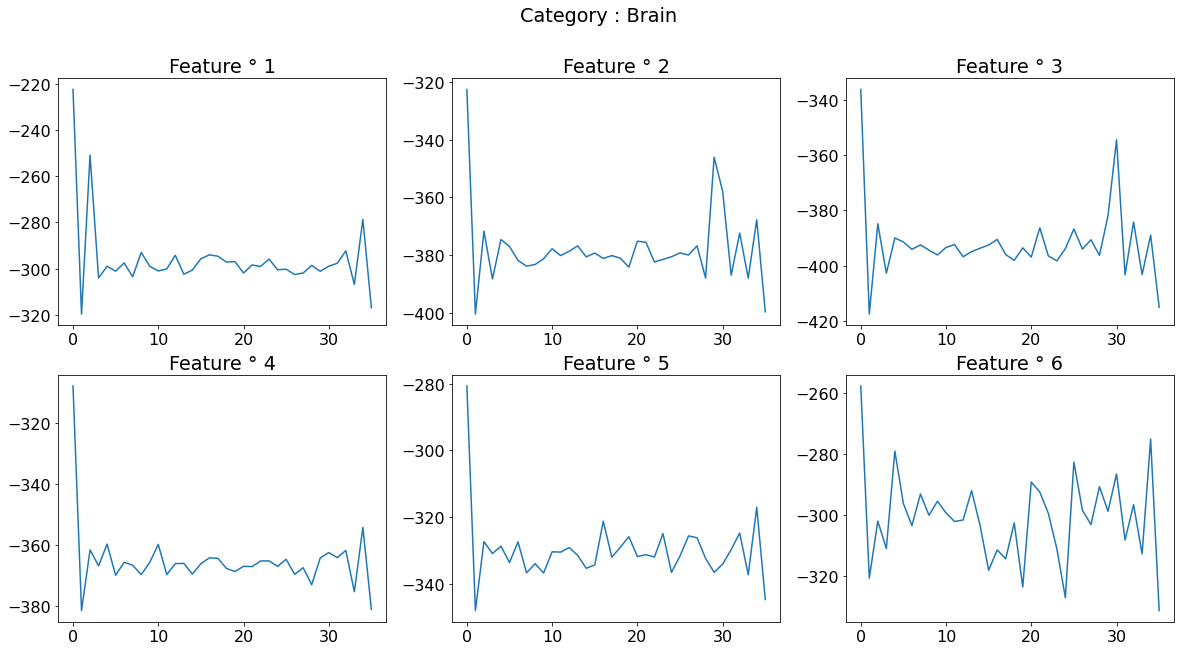

In [14]:
# Verification of the scaling impact on some examples

random_index=np.random.randint(0,2428) 

print("ORIGINAL :")
plot_example(random_index,x_train_val,y_train_val)

SCALED :


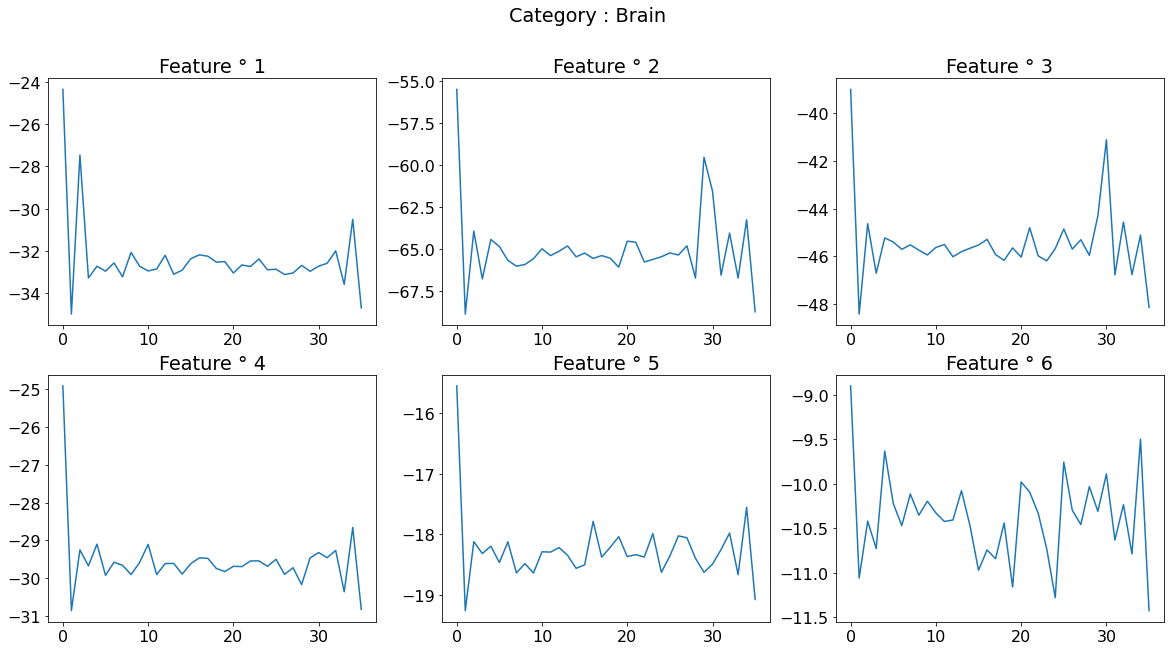

In [15]:
print("SCALED :")
plot_example(random_index,x_train_val_scaled,y_train_val)

In [54]:
# SPLITTING

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_val_scaled,y_train_val, test_size = 0.1, random_state=seed,stratify= y_train_val )

In [ ]:
# Demultiplying data with window stride on whole dataset (by class and variable)

TOTAL :  2186


{'Wish': 30,
 'Another': 111,
 'Comfortably': 243,
 'Money': 343,
 'Breathe': 56,
 'Time': 138,
 'Brain': 282,
 'Echoes': 61,
 'Wearing': 108,
 'Sorrow': 699,
 'Hey': 69,
 'Shine': 46}

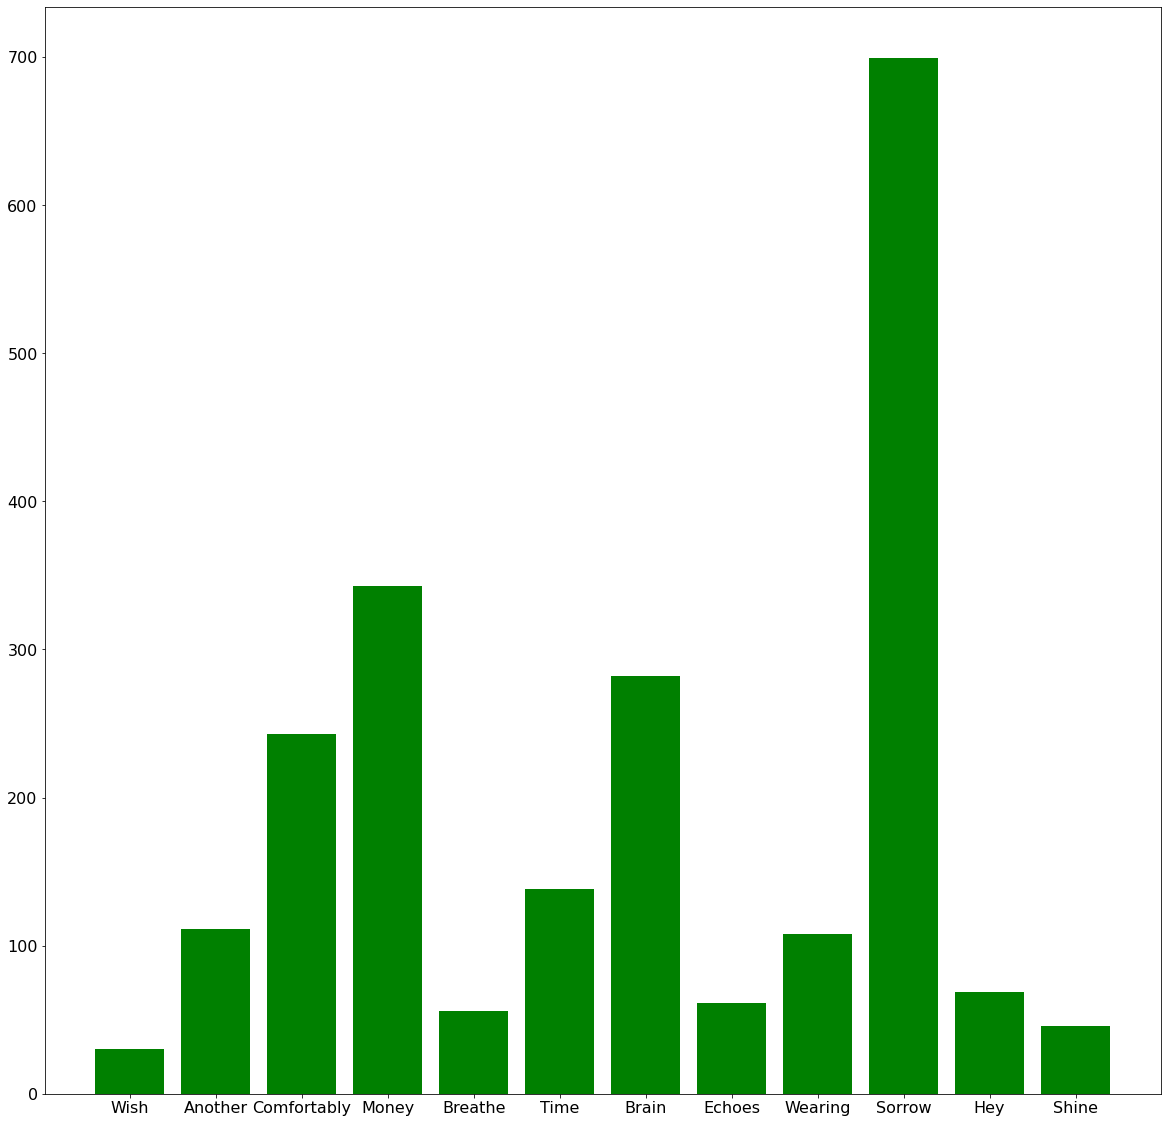

In [85]:
class_repartitions=class_rep(y_train)
class_repartitions

In [112]:
# define the stride to set for each class, in order to obtain a more or less 
# balanced dataset(underrpz class==>small stride==>demultiply more; overrpz class==>big stride 
# ==> demultiply less).

strides={0: 0,
1: 0,
2: 0,
3: 0,
4: 0,
5: 0,
6: 0,
7: 0,
8: 0,
9: 0,
10: 0,
11: 0}

n_samples_max_class=max(class_repartitions.values())
stride_max_class=12
n_samples_max_class_new = n_samples_max_class * 36 / stride_max_class

for c in range(12):
    n_samples_c=class_repartitions[labels[c]]
    obj=n_samples_max_class_new
    stride_c = int(n_samples_c * 36/obj)+1
    while ((36 % stride_c)!=0):
        stride_c=stride_c+1
    strides[c]=stride_c

strides
    

    


{0: 2, 1: 4, 2: 9, 3: 18, 4: 3, 5: 6, 6: 12, 7: 3, 8: 4, 9: 36, 10: 3, 11: 2}

In [113]:
def build_sequences(df, window, stride):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    # Take only meaningful features
    temp = df[[0,1,2,3,4,5]].values
    # Save the label
    label = df['class'].values[0]
    idx=0
    while idx+window <= len(temp):
        dataset.append(temp[idx:idx+window])
        labels.append(label)
        idx += stride
    

                
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [114]:
x_train_flattened, y_train_flattened = flatten(x_train,y_train)
df=pd.DataFrame(x_train_flattened)
df["class"] = y_train_flattened
df["class_name"] = [ labels[y] for y in y_train_flattened]

df_0=df[df["class"]==0]
X_0,Y_0=build_sequences(df_0,window=36,stride=strides[0])
X_train,Y_train=X_0,Y_0
print (X_0.shape, " = ? ", (int((len(df_0)-36)/strides[0]) + 1 ,36,6)," ; ",Y_0.shape)

for c in range(12):
    df_c=df[df["class"]==c]
    X_c, Y_c=build_sequences(df_c,window=36,stride=strides[c])
    print (X_c.shape, " = ? ", (int((len(df_c)-36)/strides[c]) + 1 ,36,6)," ; ",Y_c.shape)
    X_train = np.concatenate((X_train, X_c))
    Y_train = np.concatenate((Y_train, Y_c))

        
X_train= np.array(X_train)
Y_train= np.array(Y_train)
print()
print (X_train.shape," ; ",Y_train.shape)

(523, 36, 6)  = ?  (523, 36, 6)  ;  (523,)
(523, 36, 6)  = ?  (523, 36, 6)  ;  (523,)
(991, 36, 6)  = ?  (991, 36, 6)  ;  (991,)
(969, 36, 6)  = ?  (969, 36, 6)  ;  (969,)
(685, 36, 6)  = ?  (685, 36, 6)  ;  (685,)
(661, 36, 6)  = ?  (661, 36, 6)  ;  (661,)
(823, 36, 6)  = ?  (823, 36, 6)  ;  (823,)
(844, 36, 6)  = ?  (844, 36, 6)  ;  (844,)
(721, 36, 6)  = ?  (721, 36, 6)  ;  (721,)
(964, 36, 6)  = ?  (964, 36, 6)  ;  (964,)
(699, 36, 6)  = ?  (699, 36, 6)  ;  (699,)
(817, 36, 6)  = ?  (817, 36, 6)  ;  (817,)
(811, 36, 6)  = ?  (811, 36, 6)  ;  (811,)

(10031, 36, 6)  ;  (10031,)


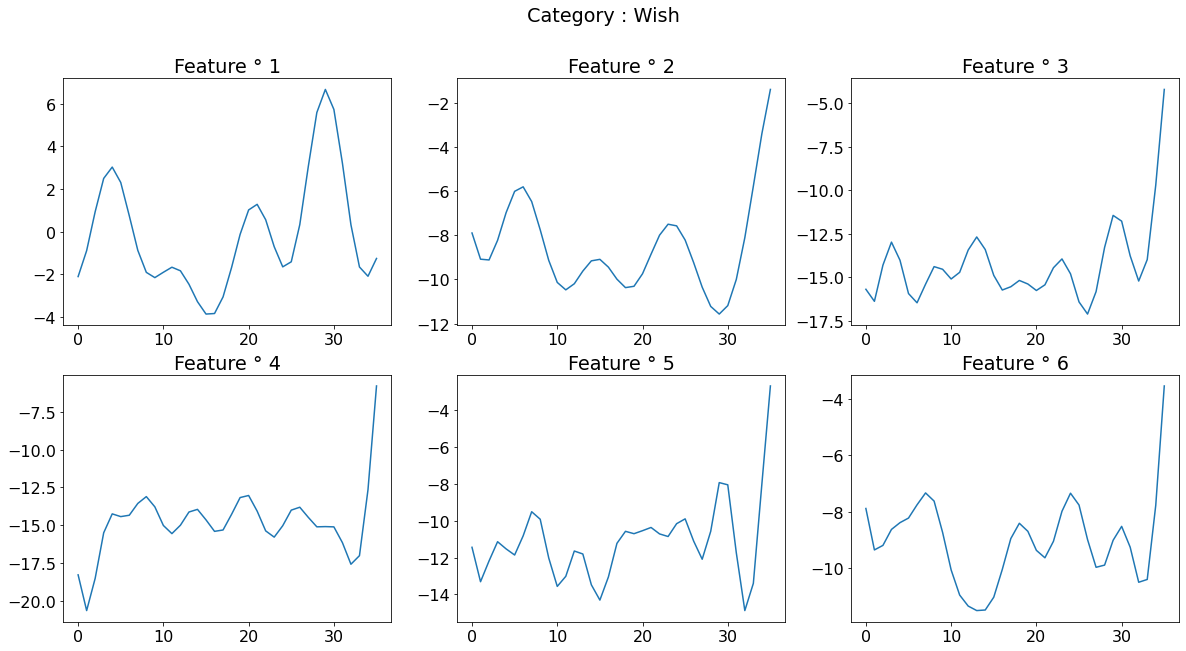

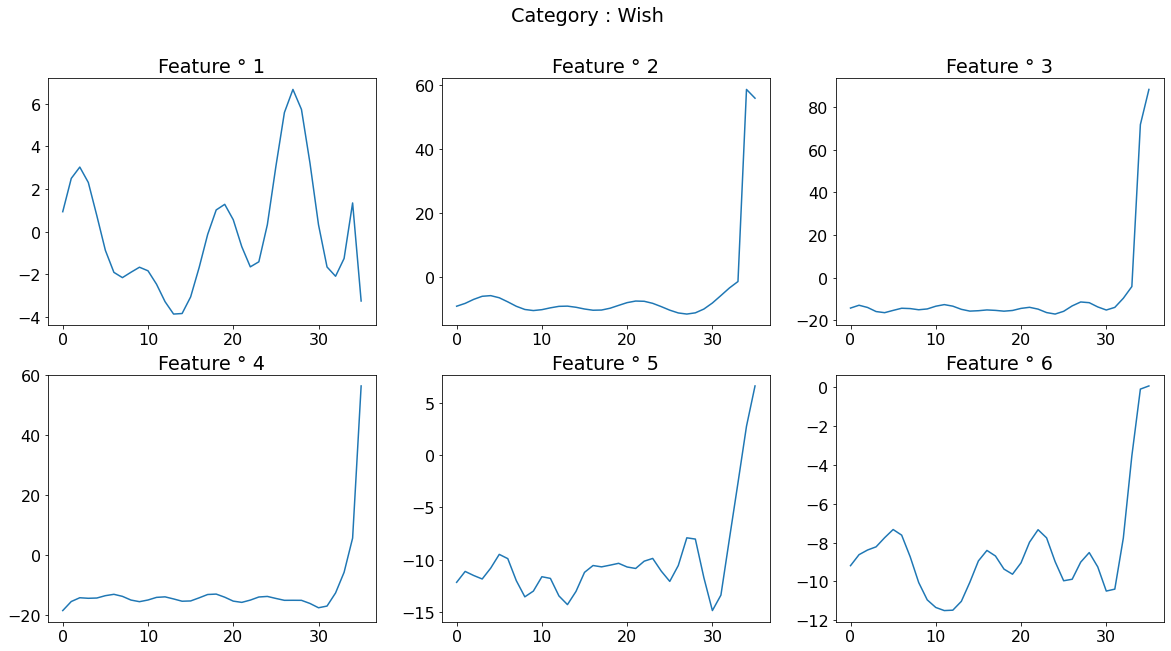

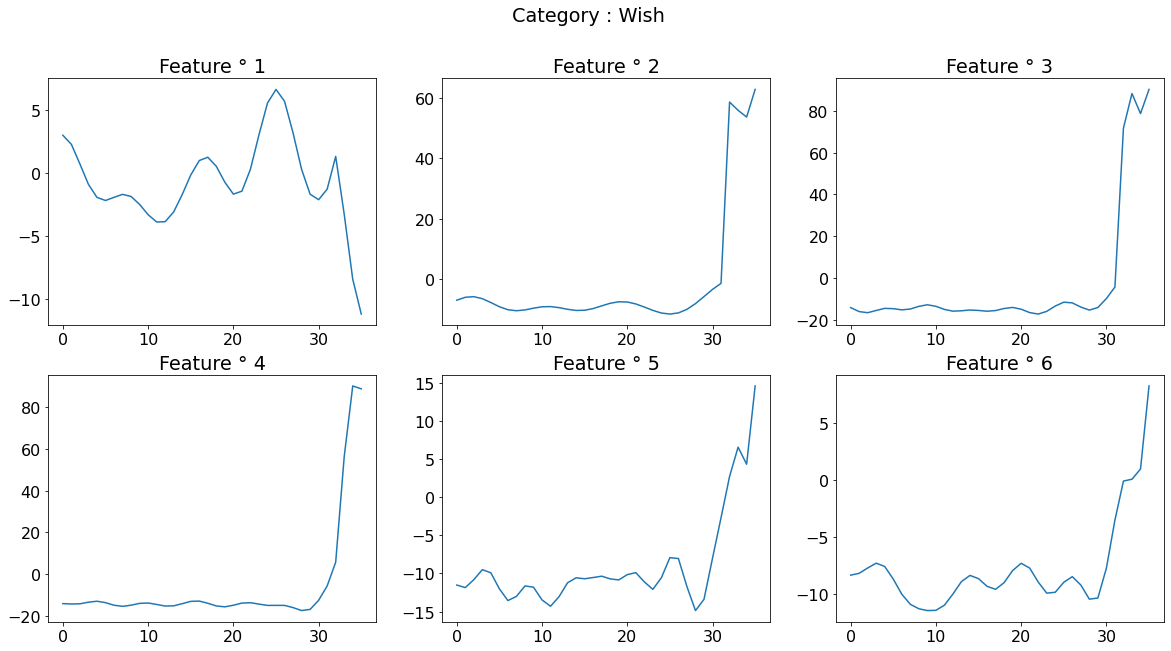

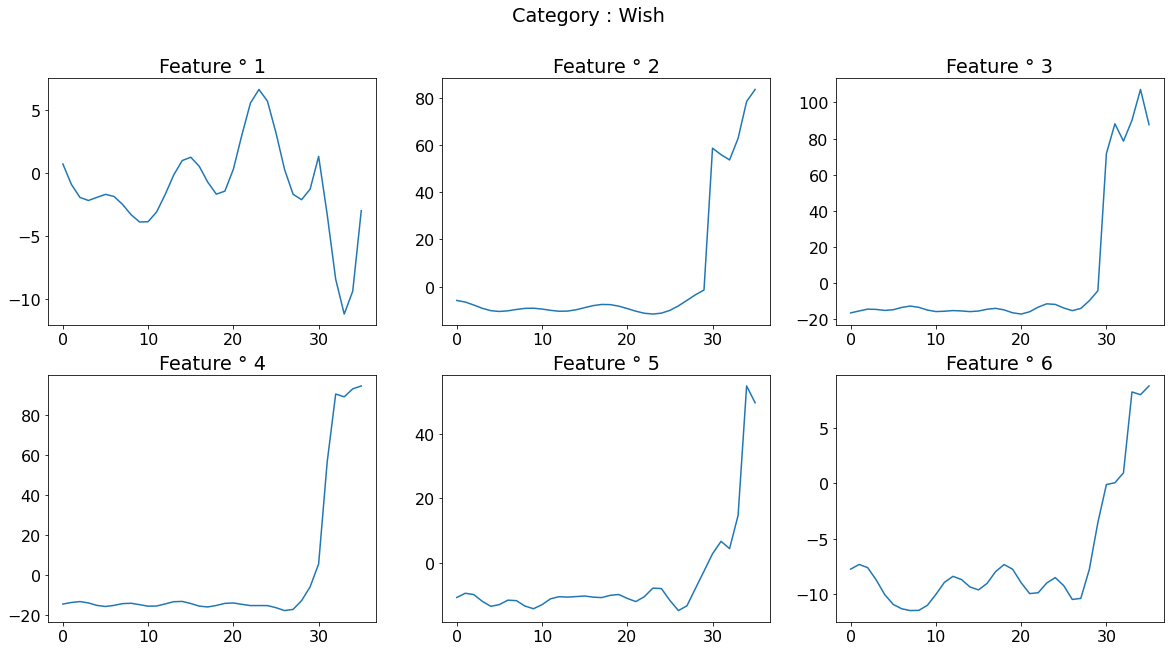

In [115]:
plot_example(0,X_train,Y_train)
plot_example(1,X_train,Y_train)
plot_example(2,X_train,Y_train)
plot_example(3,X_train,Y_train)

TOTAL :  10031


{'Wish': 1046,
 'Another': 991,
 'Comfortably': 969,
 'Money': 685,
 'Breathe': 661,
 'Time': 823,
 'Brain': 844,
 'Echoes': 721,
 'Wearing': 964,
 'Sorrow': 699,
 'Hey': 817,
 'Shine': 811}

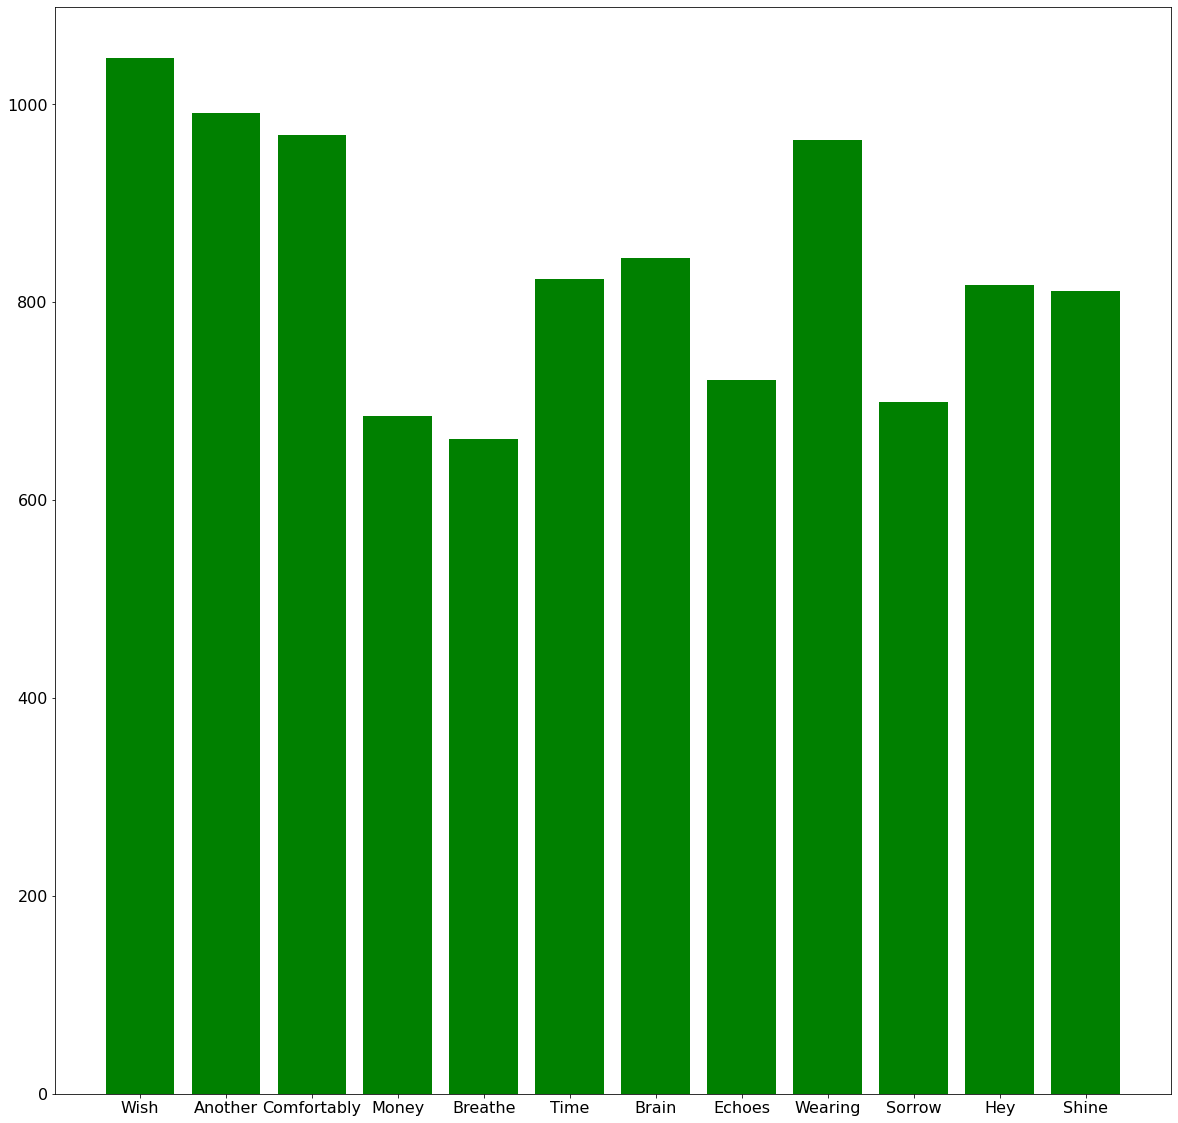

In [116]:
class_rep(Y_train)

In [117]:
# Encoding target variable

Y_train_categorical = tfk.utils.to_categorical(Y_train)
y_val_categorical =  tfk.utils.to_categorical(y_val)

print(Y_train_categorical.shape,y_val_categorical.shape )

(10031, 12) (243, 12)


In [ ]:
# MODEL BUILDING

In [104]:
input_shape = X_train.shape[1:]
classes = Y_train_categorical.shape[-1]
batch_size = 128
epochs = 200

In [ ]:
# Computing weighted_loss

In [122]:
def build_VGG(input_shape):
    vgg_weight = tfk.Sequential()

    vgg_weight.add(tfkl.Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
    vgg_weight.add(tfkl.MaxPooling1D(pool_size=2,strides=2))
    vgg_weight.add(tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.MaxPooling1D(pool_size=2,strides=2))
    vgg_weight.add(tfkl.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.MaxPooling1D(pool_size=2,strides=2))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.MaxPooling1D(pool_size=2,strides=2))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg_weight.add(tfkl.MaxPooling1D(pool_size=2,strides=2))
    vgg_weight.add(tfkl.GlobalAveragePooling1D())
    vgg_weight.add (tfkl.Dropout(0.4))
    vgg_weight.add (tfkl.Dense(512, activation='relu'))
    vgg_weight.add (tfkl.Dropout(0.4))
    vgg_weight.add (tfkl.Dense(12,activation='softmax'))


    learning_rate = 0.001
    vgg_weight.compile(
        optimizer = tfk.optimizers.Adam(),
        loss = tfk.losses.CategoricalCrossentropy(),
        metrics = ['accuracy' ]
    )
    return vgg_weight

In [123]:
model = build_VGG(input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 36, 64)            1216      
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 36, 64)            12352     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 18, 64)            0         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 18, 128)           24704     
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 9, 256)           

In [ ]:
# TRAINING PHASE

In [124]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val_categorical),
     callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-5)
    ]

    
   
).history

Epoch 1/200
79/79 [==============================] - 3s 27ms/step - loss: 2.1245 - accuracy: 0.2259 - val_loss: 2.0056 - val_accuracy: 0.1728
Epoch 2/200
79/79 [==============================] - 1s 17ms/step - loss: 1.5979 - accuracy: 0.3922 - val_loss: 1.9206 - val_accuracy: 0.2428
Epoch 3/200
79/79 [==============================] - 1s 17ms/step - loss: 1.3494 - accuracy: 0.4860 - val_loss: 1.6116 - val_accuracy: 0.2675
Epoch 4/200
79/79 [==============================] - 1s 17ms/step - loss: 1.1779 - accuracy: 0.5429 - val_loss: 1.6328 - val_accuracy: 0.2922
Epoch 5/200
79/79 [==============================] - 1s 17ms/step - loss: 1.0245 - accuracy: 0.5969 - val_loss: 1.5858 - val_accuracy: 0.3663
Epoch 6/200
79/79 [==============================] - 2s 22ms/step - loss: 0.9169 - accuracy: 0.6466 - val_loss: 1.7774 - val_accuracy: 0.2963
Epoch 7/200
79/79 [==============================] - 2s 20ms/step - loss: 0.8767 - accuracy: 0.6623 - val_loss: 1.3284 - val_accuracy: 0.4033
Epoch 

Accuracy: 0.7119
Precision: 0.7187
Recall: 0.6179
F1: 0.6458


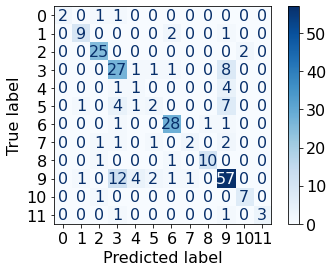

In [125]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix and Classification Report
# Y_pred = model_gap.predict_generator(valid_gen,  706// batch_size+1)
Y_pred = model.predict(x_val)
y_pred = np.argmax(Y_pred, axis=1)

cm=confusion_matrix(y_val, y_pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_categorical, axis=-1), np.argmax(Y_pred, axis=-1))
precision = precision_score(np.argmax(y_val_categorical, axis=-1), np.argmax(Y_pred, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_categorical, axis=-1), np.argmax(Y_pred, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_categorical, axis=-1), np.argmax(Y_pred, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))



In [127]:
import shutil

model.save('vgg_1D')
shutil.make_archive("vgg_1D", 'zip', './vgg_1D')

'/kaggle/working/vgg_1D.zip'